In [1]:
# Path
import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)

## Kernel Gram Matrix estimation

In [2]:
import numpy as np
from  kernelfuzzy.fuzzyset import FuzzySet
from  kernelfuzzy.memberships import gaussmf
from  kernelfuzzy.fuzzification import FuzzyData, get_mean_and_std_matrix
from kernelfuzzy.kernels import nonsingleton_gaussian_kernel, gram_matrix_nonsingleton_gaussian_kernel
import seaborn as sns
from typing import Callable, List
from numba import njit
from kernelfuzzy.fuzzysystem import *
from sklearn.datasets.samples_generator import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0)


#nonsingleton fuzzification
fuzzy_data=NonSingletonFuzzifier( std_proportion=0.3, constant_std=True ).transform(X)
mean_X,sigma_X=get_mean_and_std_matrix(fuzzy_data)
print(mean_X)
print(sigma_X)
print(X)


[[-0.07882731 -0.28144368 -2.1180247  ...  0.02007743 -1.32566385
  -1.23907431]
 [ 0.68846997  0.3652008   0.12899717 ... -0.43013587  1.07863197
  -2.45792444]
 [-0.49903044  1.78439016 -0.45690318 ...  0.45382926  0.74439273
  -0.51373064]
 ...
 [ 0.02163518  1.54625372  2.21980442 ...  0.06917782  0.24378101
   0.33722275]
 [-0.54166799  0.68171443 -0.2582733  ... -0.32831791  0.85578564
   1.70108675]
 [ 0.61106285  0.19693082 -1.75140643 ... -0.64534262 -0.10658172
  -1.90017788]]
[[0.3 0.3 0.3 ... 0.3 0.3 0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]
 ...
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]
 [0.3 0.3 0.3 ... 0.3 0.3 0.3]]
[[-0.07882731 -0.28144368 -2.1180247  ...  0.02007743 -1.32566385
  -1.23907431]
 [ 0.68846997  0.3652008   0.12899717 ... -0.43013587  1.07863197
  -2.45792444]
 [-0.49903044  1.78439016 -0.45690318 ...  0.45382926  0.74439273
  -0.51373064]
 ...
 [ 0.02163518  1.54625372  2.21980442 ...  0.06917782  0.24378101
  

In [4]:

@njit
def gram_matrix_nonsingleton_gaussian_kernel_njit(mean_X:np.ndarray, 
                                                  mean_Y:np.ndarray, 
                                                  sigma_X:np.ndarray, 
                                                  sigma_Y:np.ndarray, 
                                                  param:float)-> np.ndarray:

        '''

        Calculates the Gram matrix using the nonsingleton Gaussian kernel on fuzzy sets
        optimized for Numba

        Input:
            mean_X, sigma_X:     matrix of parameters for fuzzy data X (Type: FuzzyData)
            mean_Y, sigma_Y:     matrix of parameters for fuzzy data Y (Type: FuzzyData)
            param:                  (Type: float) kernel parameter

        Output:
            (Type: numpy.ndarray) kernel matrix

        '''


        gram_matrix = np.zeros((mean_X.shape[0], mean_Y.shape[0]))

        if mean_X is mean_Y: # use symmetry property
            N=mean_X.shape[0]

            for i in range(0,N):
                for j in range(i, N):

                    value = 1
                    for mean_x, mean_y,sigma_x,sigma_y in zip(mean_X[i,:], mean_Y[j,:], sigma_X[i,:], sigma_Y[j,:]):
                        value = value * (np.exp(-0.5 * param * (mean_x - mean_y) ** 2 / (sigma_x ** 2 + sigma_y ** 2)))

                    gram_matrix[i, j] = value
                    gram_matrix[j, i] = value
            #tikonov regularization
            gram_matrix=gram_matrix+np.eye(N)*np.nextafter(0,1)


        else: # X and Y are different
            N=mean_X.shape[0]
            M=mean_Y.shape[0]

            for i in range(0,N):
                for j in range(0, M):

                    value = 1
                    for mean_x, mean_y,sigma_x,sigma_y in zip(mean_X[i,:], mean_Y[j,:], sigma_X[i,:], sigma_Y[j,:]):
                        value = value * (np.exp(-0.5 * param * (mean_x - mean_y) ** 2 / (sigma_x ** 2 + sigma_y ** 2)))

                    gram_matrix[i, j] = value

        return gram_matrix

## Kernel Gram Matrix different bandwiths for the nonsingleton gaussian kernel on fuzzy sets


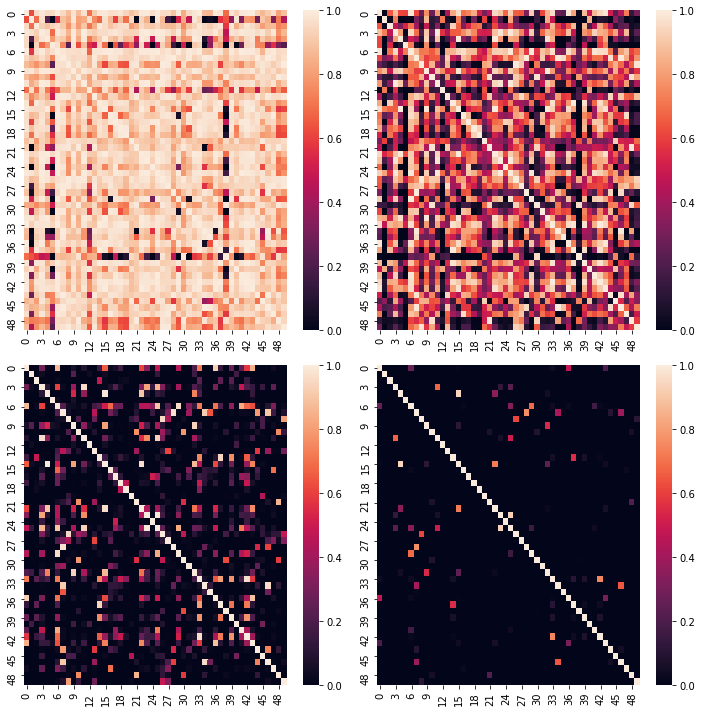

In [4]:
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

# fuzzy dataset
fuzzy_dataset = FuzzyData.create_toy_fuzzy_dataset(num_rows=50, num_cols=2)

kernel_bandwidth=[0.05, 0.5, 5, 50]

# plotting
fig, axn = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axn.flat):
    K = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_dataset, fuzzy_dataset, param=kernel_bandwidth[i])
    sns.heatmap(K, ax=ax)

fig.tight_layout()

# Non singleton kernel with nonsingleton fuzzification for a dataset

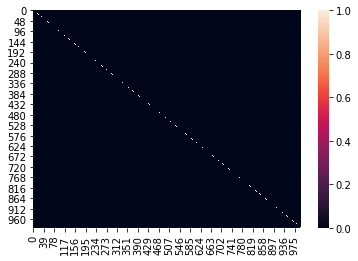

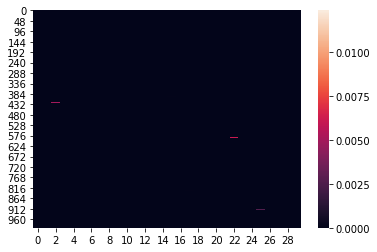

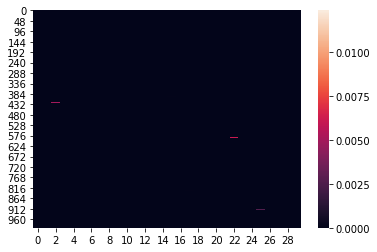

[[1.00000000e+00 1.42021575e-31 1.72770067e-27 ... 4.52449630e-20
  4.95141540e-25 3.42472874e-25]
 [1.42021575e-31 1.00000000e+00 6.90371414e-44 ... 3.71171684e-27
  2.79501714e-13 2.60940617e-27]
 [1.72770067e-27 6.90371414e-44 1.00000000e+00 ... 1.50621672e-24
  7.12607516e-31 4.80584307e-40]
 ...
 [4.52449630e-20 3.71171684e-27 1.50621672e-24 ... 1.00000000e+00
  3.29745958e-19 2.07268155e-34]
 [4.95141540e-25 2.79501714e-13 7.12607516e-31 ... 3.29745958e-19
  1.00000000e+00 1.11497005e-12]
 [3.42472874e-25 2.60940617e-27 4.80584307e-40 ... 2.07268155e-34
  1.11497005e-12 1.00000000e+00]]
K_
[[1.56152438e-37 2.27410956e-29 5.16340309e-31 ... 2.33072770e-20
  9.98655999e-15 2.69789462e-48]
 [6.04806581e-23 2.35690226e-40 4.71964384e-33 ... 1.99846740e-43
  1.28852343e-47 1.81301524e-52]
 [1.61932219e-30 9.28563228e-22 3.39867624e-16 ... 1.23626076e-15
  5.06330407e-34 4.08624880e-43]
 ...
 [2.57652160e-25 2.05255261e-17 2.19092510e-17 ... 3.18523859e-20
  2.21167759e-18 1.59669054e-

In [6]:
from kernelfuzzy.fuzzysystem import *
from sklearn.datasets.samples_generator import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0,random_state=1)
X_test, y = make_classification(n_samples=30, n_features=10, n_informative=3, n_redundant=0,random_state=1)


#nonsingleton fuzzification
fuzzy_data=NonSingletonFuzzifier( std_proportion=0.3, constant_std=True ).transform(X)
#%timeit K = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data, fuzzy_data, param=1)
K = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data, fuzzy_data, param=1)
ax = sns.heatmap(K)
plt.show()
fuzzy_data_=NonSingletonFuzzifier(std_proportion=0.3, constant_std=True ).transform(X_test)
#%timeit K_ = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data, fuzzy_data_, param=1)
K_ = gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data, fuzzy_data_, param=1)
ax = sns.heatmap(K_)
plt.show()


#get the values from fuzzy data
mean_X, sigma_X = get_mean_and_std_matrix(fuzzy_data)
mean_Y, sigma_Y = get_mean_and_std_matrix(fuzzy_data_)

#%timeit K__=gram_matrix_nonsingleton_gaussian_kernel_njit(mean_X,mean_Y,sigma_X,sigma_y,1)
K__=gram_matrix_nonsingleton_gaussian_kernel_njit(mean_X,mean_Y,sigma_X,sigma_Y,1)
ax = sns.heatmap(K__)
plt.show()

print(K)
print('K_')
print(K_)
print('K__')
print(K__)

In [6]:
import profile
profile.run("gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data, fuzzy_data, param=1)")
profile.run("gram_matrix_nonsingleton_gaussian_kernel_njit(mean_X,mean_Y,sigma_X,sigma_y,1)")


         15015008 function calls in 88.731 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   88.730   88.730 :0(exec)
        1    0.001    0.001    0.001    0.001 :0(setprofile)
        2    0.008    0.004    0.008    0.004 :0(zeros)
        1    0.001    0.001   88.730   88.730 <string>:1(<module>)
 10010000   14.491    0.000   14.491    0.000 fuzzyset.py:71(get_membership_function_params)
  5005000   56.236    0.000   70.726    0.000 kernels.py:169(nonsingleton_gaussian_kernel)
        1   17.994   17.994   88.729   88.729 kernels.py:249(gram_matrix_nonsingleton_gaussian_kernel)
        1    0.000    0.000   88.731   88.731 profile:0(gram_matrix_nonsingleton_gaussian_kernel(fuzzy_data, fuzzy_data, param=1))
        0    0.000             0.000          profile:0(profiler)
        1    0.000    0.000    0.004    0.004 twodim_base.py:154(eye)


         5 function calls in 0.333 seconds

   Orde

In [6]:
16.2 s ± 901 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.4 s ± 2.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

16 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
32 s ± 1.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

np.prod with list comprehension
23.7 s ± 3.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.4 s ± 3.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


SyntaxError: invalid syntax (<ipython-input-6-4768952a803c>, line 1)

In [19]:
mean_X=mean_Y=np.random.random((2,2))
sigma_X=sigma_y=np.random.random((2,2))
gram_matrix_nonsingleton_gaussian_kernel_njit(mean_X,mean_Y,sigma_X,sigma_y,1)

array([[1.        , 0.96972058],
       [0.96972058, 1.        ]])

In [17]:
print(K)
print('K_')
print(K_)
print('K__')
print(K__)



[[1.00000000e+00 9.93211919e-62 2.61048905e-31 ... 1.98109762e-31
  6.88093195e-43 8.91516582e-44]
 [9.93211919e-62 1.00000000e+00 7.60432976e-41 ... 3.69043567e-21
  1.50306104e-42 1.34475310e-24]
 [2.61048905e-31 7.60432976e-41 1.00000000e+00 ... 7.09274310e-17
  1.60632736e-24 2.33874361e-38]
 ...
 [1.98109762e-31 3.69043567e-21 7.09274310e-17 ... 1.00000000e+00
  2.40080297e-25 6.89415799e-31]
 [6.88093195e-43 1.50306104e-42 1.60632736e-24 ... 2.40080297e-25
  1.00000000e+00 2.97241338e-52]
 [8.91516582e-44 1.34475310e-24 2.33874361e-38 ... 6.89415799e-31
  2.97241338e-52 1.00000000e+00]]
K_
[[3.09530131e-37 2.13479078e-40 8.49200216e-21 ... 6.73290940e-33
  1.60200989e-22 6.96288954e-47]
 [2.61995323e-27 1.26284175e-53 1.00923236e-57 ... 1.16680608e-36
  2.99218171e-22 9.31464221e-36]
 [4.81452221e-25 7.90965470e-14 2.62842130e-32 ... 2.00278751e-16
  7.93650360e-21 1.14882613e-25]
 ...
 [1.86898991e-17 1.05245873e-31 1.21396916e-41 ... 2.33319967e-15
  2.16193711e-15 4.10964502e-